**Program 6: Use PyTorch to build and train the LeNet-5 architecture on the MNIST dataset. Define hyperparameters, train the model, test its performance, and run your code to generate classification accuracy, precision, recall, F1 scores and training/validation plots.**

Epoch [1/10], Train Loss: 0.2462, Validation Loss: 0.0862, Validation Accuracy: 0.9722
Epoch [2/10], Train Loss: 0.0700, Validation Loss: 0.0506, Validation Accuracy: 0.9835
Epoch [3/10], Train Loss: 0.0505, Validation Loss: 0.0416, Validation Accuracy: 0.9869
Epoch [4/10], Train Loss: 0.0395, Validation Loss: 0.0441, Validation Accuracy: 0.9869
Epoch [5/10], Train Loss: 0.0331, Validation Loss: 0.0308, Validation Accuracy: 0.9894
Epoch [6/10], Train Loss: 0.0272, Validation Loss: 0.0369, Validation Accuracy: 0.9892
Epoch [7/10], Train Loss: 0.0240, Validation Loss: 0.0454, Validation Accuracy: 0.9861
Epoch [8/10], Train Loss: 0.0211, Validation Loss: 0.0343, Validation Accuracy: 0.9884
Epoch [9/10], Train Loss: 0.0195, Validation Loss: 0.0432, Validation Accuracy: 0.9850
Epoch [10/10], Train Loss: 0.0171, Validation Loss: 0.0386, Validation Accuracy: 0.9890
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0

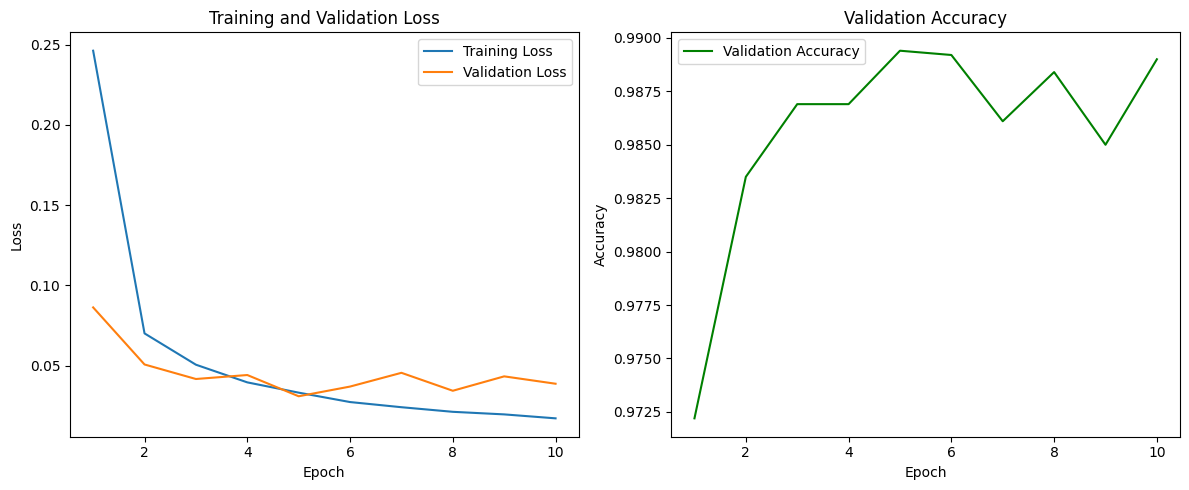

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)  # Flatten feature maps
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

# Data preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_losses.append(val_loss / len(test_loader))
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Testing and evaluation metrics
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(classification_report(all_labels, all_preds))

print(f'Overall Accuracy: {accuracy:.4f}')
print(f'Overall Precision: {precision:.4f}')
print(f'Overall Recall: {recall:.4f}')
print(f'Overall F1 Score: {f1:.4f}')

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.tight_layout()
plt.show()